In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
version = '04'

Using TensorFlow backend.


In [2]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)
        
class LossHistory(Callback):
    def __init__(self, number_of_epochs):
        self.number_of_epochs = number_of_epochs
        self.current_epoch = 0
    def on_train_begin(self, logs={}):
        self.initial_time = time.time()
    def on_batch_end(self, batch, logs={}):
        if logs['batch']==0:
            NUMBER_OF_DIESIS = 20
            self.current_epoch += 1
            progress = self.current_epoch/self.number_of_epochs
            diesis = np.round(progress*NUMBER_OF_DIESIS).astype('int')
            eta = (time.time()-self.initial_time) * (self.number_of_epochs/self.current_epoch -1)
            remaining_time = time.strftime("%Mmin %Ssec", time.gmtime(eta))
            print('\r[{}{}] acc:{:.3f} eta:{}'.format('#'*diesis, '-'*(NUMBER_OF_DIESIS-diesis), logs['acc'], remaining_time), end='')

## Dataset loading

In [10]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [11]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X_load = np.array(batch_right + batch_left)
y_load = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [12]:
print(f'X shape: {X_load.shape}\ny shape: {y_load.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [13]:
X_diff = X_load[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X_load[:,:,0])
X_diff[:,:,1] = np.diff(X_load[:,:,1])

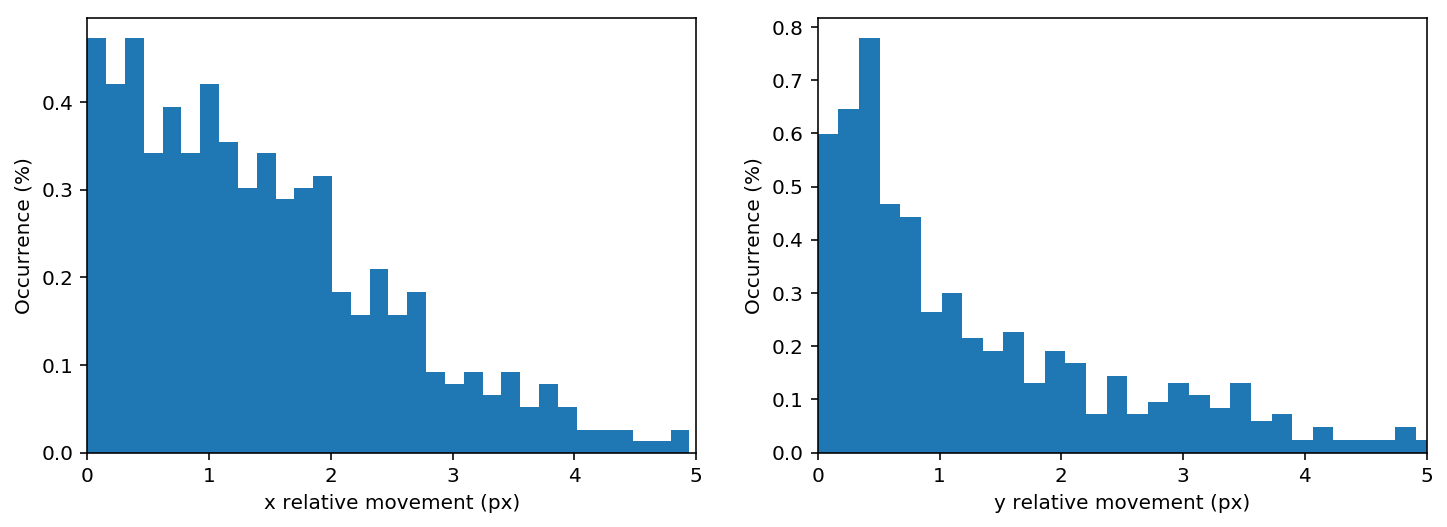

In [14]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)
mask = (sigma_x>0.1)*(sigma_y>0.1)

X_filt = X_diff[mask]
y_filt = y_load[mask]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

X = X_filt
y = y_filt

#fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

## Model definition

In [145]:
def add_grid_and_save(grid, version):
    if os.path.isfile('../model_data/grid_{}.pkl'.format(grid['version'][1])):
        grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))
    else:
        grid_df = pd.DataFrame()
        for key in sorted(grid.keys()):
            grid_df[key] = pd.Series(dtype=grid[key][0])
    
    grid_df = grid_df.append({key:grid[key][1] for key in grid.keys()}, ignore_index=True)
    grid_df.to_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))


def generate_hyperparameters(params, index, version):
    best_model_path = '../models/best_model_{}_{}.pkl'.format(version, index)
    
    grid = {
        'index'                  : [np.int    , index],
        'version'                : [np.int    , version],
        'best_model_path'        : ['str'     , best_model_path],
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'], 
        'seed_random'            : [np.int    , 0],
        'seed_sklearn'           : [np.int    , 0],
        'seed_model'             : [np.int    , 0],
        'seed_skf'               : [np.int    , params[0]],
        'seed_numpy'             : [np.int    , 0],
        'seed_tensorflow'        : [np.int    , 0],
        'LSTM_size'              : [np.int    , 256],
        'learning_rate'          : [np.float  , 0.0001],
        'batch_size'             : [np.int    , params[2]],
        'epochs'                 : [np.int    , 250],
        'test_size'              : [np.float  , 0.15],
        'skf_n_splits'           : [np.int    , 5],
        'skf_split'              : [np.int    , params[1]],
        'fit_out'                : ['O'       , None]}

    return grid


def create_train_dev_test(X, y, grid):
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=grid['test_size'][1],
                                                                random_state=grid['seed_sklearn'][1], shuffle=True)
    skf = StratifiedKFold(n_splits=grid['skf_n_splits'][1], shuffle=True, random_state=grid['seed_skf'][1])

    train_index, test_index = list(skf.split(X_train_dev, y_train_dev))[grid['skf_split'][1]]
    X_train, X_dev = X_train_dev[train_index], X_train_dev[test_index]
    y_train, y_dev = y_train_dev[train_index], y_train_dev[test_index]
    bb.append([X_test, y_test])
        
    return X_train, X_dev, X_test, y_train, y_dev, y_test


def create_model(grid, input_shape):
    model = Sequential()
    model.add(LSTM(grid['LSTM_size'][1], input_shape=input_shape, kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    return model

def train_model(X_train, X_dev, y_train, y_dev, model, grid):
    adam = Adam(lr=grid['learning_rate'][1])
    progrress_bar = LossHistory(grid['epochs'][1])
    chk = ModelCheckpoint(grid['best_model_path'][1] , monitor=grid['best_model_metric'][1],
                          save_best_only=True, mode='max', verbose=0) 
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[grid['training_metric'][1]])
    grid['fit_out'][1] = model.fit(X_train, y_train, epochs=grid['epochs'][1], batch_size=grid['batch_size'][1],
                        callbacks=[chk, progrress_bar], validation_data=(X_dev, y_dev), verbose=0)
    grid['fit_out'][1].model = None

    
def run_training(X, y, grid, verbose=True):
    initial_time = time.time()
    np.random.seed(grid['seed_numpy'][1])
    tf.set_random_seed(grid['seed_tensorflow'][1])
    random.seed(grid['seed_random'][1])

    X_train, X_dev, X_test, y_train, y_dev, y_test = create_train_dev_test(X, y, grid)

    model = create_model(grid, input_shape=(X_dev.shape[1], 2))
    train_model(X_train, X_dev, y_train, y_dev, model, grid)
    add_grid_and_save(grid, version)
    total_time = time.strftime("%Mmin %Ssec", time.gmtime((time.time() - initial_time)))
    print('  --  Model {} trained in {}'.format(grid['index'][1], total_time))


In [115]:
%%time

if not os.path.isfile('../model_data/grid_{}.pkl'.format(version)):
    initial_index = 0
else:
    grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(version))
    initial_index = grid_df['index'].max() + 1

    
# seed_skf, index_skf, batch_size
parameters_loop = list(itertools.product([1,2,3], [0,1,2], [32, 64, 128])) + list(itertools.product([1,2,3], [0,1,2], [16]))
print(f'Training {len(parameters_loop)+1} models.')

for index, params in enumerate(parameters_loop[initial_index:]):
    grid = generate_hyperparameters(params, index+initial_index, version)
    run_training(X, y, grid, verbose=True)
    
play_bell()

Training 37 models.
[####################] acc:1.000 eta:00min 00sec  --  Model 33 trained in 18min 04sec
[####################] acc:0.812 eta:00min 00sec  --  Model 34 trained in 18min 09sec
[####################] acc:0.938 eta:00min 00sec  --  Model 35 trained in 18min 16sec
Wall time: 54min 31s


In [3]:
## Clean initial columns of an old df
grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(version))
# grid_df = grid_df.drop(grid_df.index[:4]).reset_index(drop=True)
# grid_df.to_pickle('../model_data/grid_{}.pkl'.format(version))

In [6]:
def accuracy_history_mean(df):
    accuracy_histories = [row.history['val_acc'] for row in df.values]
    return list(np.mean(accuracy_histories, axis=0))

def loss_history_mean(df):
    loss_histories = [row.history['val_loss'] for row in df.values]
    return list(np.mean(loss_histories, axis=0))

accuracy_history = grid_df.groupby(['batch_size'])['fit_out'].aggregate(accuracy_history_mean)
loss_history = grid_df.groupby(['batch_size'])['fit_out'].aggregate(loss_history_mean)

Text(0, 0.5, 'Loss')

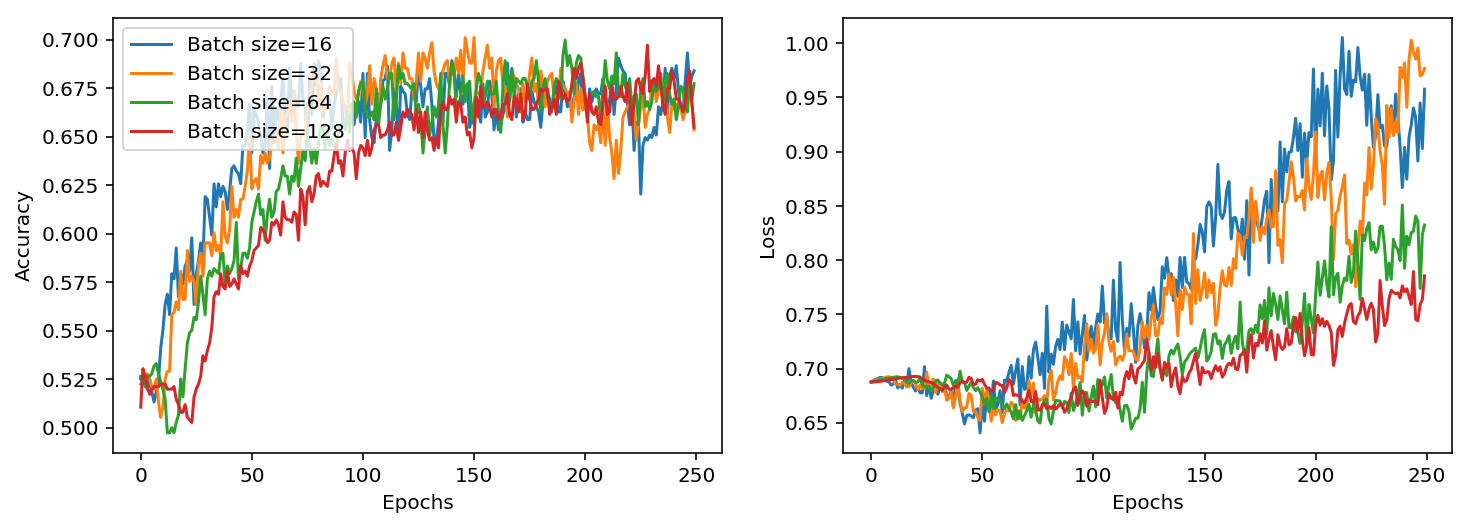

In [11]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,4))

for index, acc in accuracy_history.iteritems():
    ax.plot(acc, label=f'Batch size={index}')
    
for index, loss in loss_history.iteritems():
    ax2.plot(loss, label=f'Batch size={index}')
    
ax.legend(loc=2)
# ax.set_xlim(0, len(accuracy))
#ax.set_ylim(0.4, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
#fig.savefig(f'../plots/model_{version}_comp.png', bbox_inches='tight')

In [37]:
a.get_group(16)

,LSTM_size,batch_size,best_model_metric,best_model_path,epochs,fit_out,index,learning_rate,seed_model,seed_numpy,seed_random,seed_skf,seed_sklearn,seed_tensorflow,skf_n_splits,skf_split,test_size,training_metric,version
27,256,16,val_acc,../models/best_model_04_27.pkl,250,<keras.callbacks.History object at 0x000002546...,27,0.0001,0,0,0,1,0,0,5,0,0.15,accuracy,04
28,256,16,val_acc,../models/best_model_04_28.pkl,250,<keras.callbacks.History object at 0x000002546...,28,0.0001,0,0,0,1,0,0,5,1,0.15,accuracy,04
29,256,16,val_acc,../models/best_model_04_29.pkl,250,<keras.callbacks.History object at 0x000002546...,29,0.0001,0,0,0,1,0,0,5,2,0.15,accuracy,04
30,256,16,val_acc,../models/best_model_04_30.pkl,250,<keras.callbacks.History object at 0x000002546...,30,0.0001,0,0,0,2,0,0,5,0,0.15,accuracy,04


## Model testing

In [142]:
def rate_model(model, ):
    

    dev_preds = model.predict_classes(X_dev)
    acc_dev = accuracy_score(y_dev, dev_preds)
    print(f'Accuracy on the dev set: {acc_dev*100:.1f}%')

    training_preds = model.predict_classes(X_train)
    acc_training = accuracy_score(y_train, training_preds)
    print(f'Accuracy on the training set: {acc_training*100:.1f}%')

    test_preds = model.predict_classes(X_test)
    acc_test = accuracy_score(y_test, test_preds)
    print(f'Accuracy on the training set: {acc_test*100:.1f}%')
    


    cm = confusion_matrix(y_test, test_preds)
#     cm = confusion_matrix(y_dev, dev_preds)
#     cm = confusion_matrix(y_train, training_preds)

    classes=['Right', 'Left']
    fig, ax = plt.subplots(1, figsize=(3,3))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    cm_norm = cm / cm.sum(axis=1)*100
    im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
    ax.set_title(f'Confusion matrix ({y_dev.shape[0]} samples)', size=13)


    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > 60 else "black")
    ax.set_ylabel('True label', size=12)
    ax.set_xlabel('Predicted label', size=12)

    cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
    cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
    cb.set_label('%')


In [133]:
bathes = grid_df.groupby(['batch_size'])
bathes.groups

{16: Int64Index([27, 28, 29, 30, 31, 32, 33, 34, 35], dtype='int64'),
 32: Int64Index([0, 3, 6, 9, 12, 15, 18, 21, 24], dtype='int64'),
 64: Int64Index([1, 4, 7, 10, 13, 16, 19, 22, 25], dtype='int64'),
 128: Int64Index([2, 5, 8, 11, 14, 17, 20, 23, 26], dtype='int64')}